In [ ]:
#default_exp visualize

# CNN Interpreter

> Wrapper around several model interpretability techniques 

In [ ]:
#export
from fastai2.vision.all import *
import gc
import copy
from fast_impl.core import arch_summary, get_module, min_max_scale
from IPython.display import display
import kornia

In [ ]:
from fast_impl.visualize import *

In [ ]:
path = untar_data(URLs.IMAGEWOOF_320)

lbl_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

dblock = DataBlock(blocks=(ImageBlock,CategoryBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(valid_name='val'),
                   get_y=Pipeline([parent_label,lbl_dict.__getitem__]),
                   item_tfms=Resize(320),
                   batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(path,bs=32)

You can download the model weights [here](https://drive.google.com/file/d/1YzKlEG6itLFgLn9-8ozrLpdWchSasiUB/view?usp=sharing). It's a resnet34, trained for 10 epochs, reaching around 96% accuracy

CAM model (GAP+Linear) weigths are [here](https://drive.google.com/file/d/1qx9QWwPlBZLPuG2kGitL23wZKbVeXDov/view?usp=sharing) (94% accuracy)

## 1. Class Activation Mapping (CAM)

In [ ]:
def get_cam_resnet(arch,num_classes,pretrained=True):
  body = create_body(arch,cut=-2,pretrained=pretrained);
  nf = num_features_model(body)
  head = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.Linear(nf,num_classes))
  model = nn.Sequential(body,head)
  return model

In [ ]:
model = get_cam_resnet(resnet34,dls.c,pretrained=False)
learn = Learner(dls,model,model_dir='/content/models',opt_func=ranger,metrics=error_rate)
learn.load('cam-resnet34')

In [ ]:
#export
def generate_cam(model,xb,act_path:list=[0],wt_path:list=[1,-1],with_preds=False):
    """Show CAM for a given image
    `act_path`: list of indices to reach activation maps layer
    `wt_path`: list of indices to reach weight layer
    """
    if len(xb.shape)==3: xb= xb[None]

    act_layer = get_module(model,act_path)  
    wt_layer = get_module(model,wt_path)
    with hook_output(act_layer) as hook:
      y_preds = model(xb)
      act = hook.stored
      cam = torch.einsum('ck,nkij->ncij', wt_layer.weight, act)

      #cleanup: to prevent memory-error
      del act,xb
      torch.cuda.empty_cache()
    
    if with_preds: return cam, y_preds
    return cam

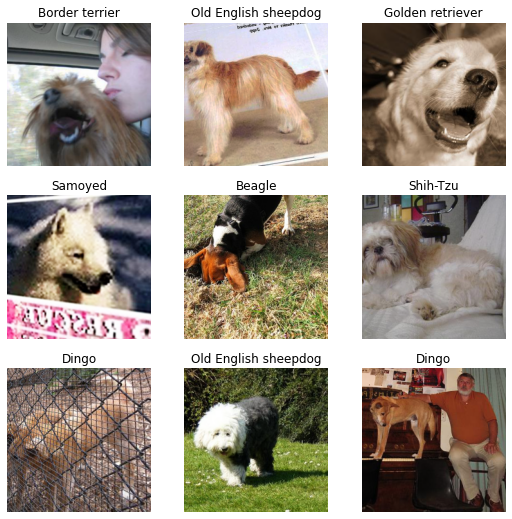

In [ ]:
xb,yb = dls.one_batch()
dls.show_batch((xb,yb))

In [ ]:
cam,y_preds = generate_cam(learn.model,xb,with_preds=True)

In [ ]:
#export
class CamImage:
  def __init__(self,x_dec,y_dec,pred_cls,cam:torch.Tensor):
    store_attr(self,'x_dec,y_dec,pred_cls,cam')
  
  def new(self,pred_cls,cam):
    x = copy.copy(self)
    x.pred_cls,x.cam = pred_cls,cam
    return x

  def show(self,ctx=None,merge=True,y_image=False,cmap='magma'):
    merge = merge and not y_image
    imsize = 5 if merge else 7
    if ctx is None: 
      _,ctx = subplots(1,1 + int(not merge),figsize=(imsize,imsize))
    else: 
      if not is_listy(ctx):
        # ctx is available, but only one, so merge
        merge=True
        ctx = [ctx]
      elif len(ctx)==2:
        # two ctx are available, so merge=False
        merge=False 
      
    ax = self.x_dec.show(ctx=ctx[0])
    ax = self.y_dec.show(ctx=ax)
    is_correct = self.pred_cls==self.y_dec
    ax = show_title(self.pred_cls,ctx=ax,color='green' if is_correct else 'red')
    alpha = 0.6 if merge else 1.
    if not y_image:
      show_heatmap(self.cam,self.x_dec.shape[-1],ax=ctx[int(not merge)],alpha=alpha,cmap=cmap)
    else:
      show_image(min_max_scale(self.cam[0]),ax=ctx[int(not merge)],alpha=alpha,cmap=cmap)

In [ ]:
#export
def get_at(batch_dec,cam_batch,y_preds,vocab,idx,for_cls=None)->CamImage:
  x,y = batch_dec[idx]
  cam_i = cam_batch[idx]
  del cam_batch # we don't need batch anymore, free-up memory
  
  if for_cls is not None:
    del y_preds
    class_id = for_cls
  else: 
    class_id = y_preds[idx].argmax(-1).item()
  return CamImage(x,y,vocab[class_id],cam_i[class_id])

def show_at(model,dl,xb,yb,idx,merge=True,for_cls=None,gen=generate_cam):
  xib,yib = xb[idx][None],yb[idx][None]
  batch_dec = dl.decode_batch((xib,yib))
  cam_b,y_preds = gen(model,xib,with_preds=True)
  get_at(batch_dec,cam_b,y_preds,dl.vocab,idx=0,for_cls=for_cls).show(merge=merge)

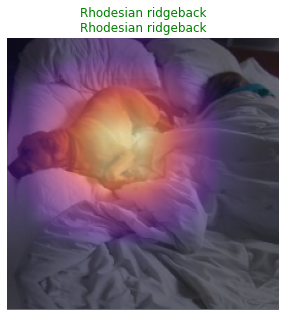

In [ ]:
show_at(learn.model,dls.valid,xb,yb,8)

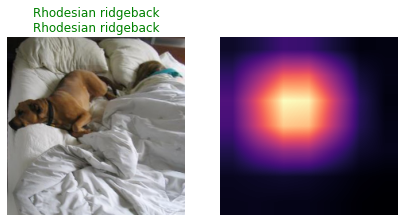

In [ ]:
show_at(learn.model,dls.valid,xb,yb,8,merge=False)

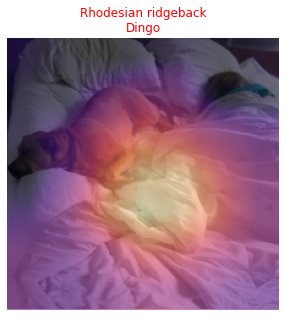

In [ ]:
show_at(learn.model,dls.valid,xb,yb,8,for_cls=3)

In [ ]:
#export
def show_cam_batch(xb,yb,cam_batch,y_preds,max_n=9,merge=True,nrows=None, ncols=None, figsize=None):
  ctxs = get_grid(min(xb.shape[0],max_n),double=(not merge),add_vert=4,title='Target/Prediction')
  batch_dec = dls.decode_batch((xb,yb))
  getter = partial(get_at,batch_dec,cam_batch,y_preds,dls.vocab)
  if merge:
    for idx,ctx in enumerate(ctxs):
      cam_img = getter(idx)
      cam_img.show(ctx=ctx)
  else:
    for idx,ctx in enumerate(zip(ctxs[0::2],ctxs[1::2])):
      cam_img = getter(idx)
      cam_img.show(ctx=ctx)

In [ ]:
xb,yb = dls.one_batch()

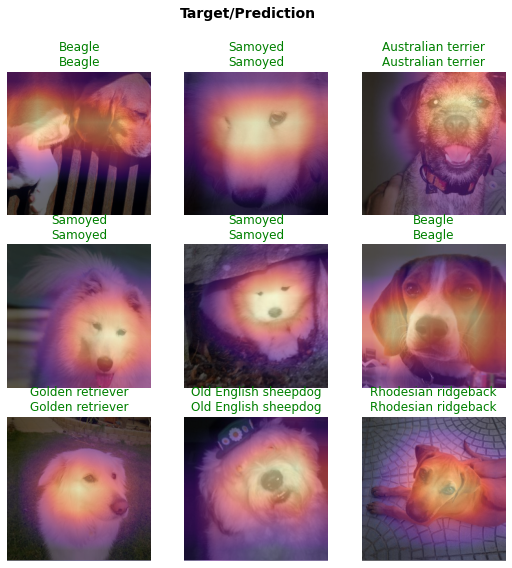

In [ ]:
cam_batch,y_preds = generate_cam(learn.model,xb,with_preds=True)
show_cam_batch(xb,yb,cam_batch,y_preds)

In [ ]:
#export
class BaseInterpreter:
  def __init__(self,model:nn.Module,valid_dl:DataLoader=None):
    self.model = copy.copy(model.eval())
    self.valid_dl = ifnone(valid_dl,copy.copy(dls.valid))
    self.valid_dl.shuffle=True
    self.vocab = valid_dl.vocab
  
  @classmethod
  def from_learner(cls,learn:Learner,ds_idx=1,dl=None):
    if dl is None: dl = learn.dls[ds_idx]
    return cls(learn.model,dl)
  
  @classmethod
  def is_cam_compatible(cls,model:nn.Module):
    """Check whether model is compatible for CAM
    The requirement is `GlobalAveragePooling` should be the penultimate layer 
    """
    avg_idx=-1
    layers = flatten_model(model)
    for idx,layer in enumerate(layers):
      if isinstance(layer,(nn.AvgPool2d,nn.AdaptiveAvgPool2d)):
        avg_idx = len(layers) - idx - 1
    if not avg_idx in [1,2]: return False #AvgPool is not penultimate
    return True

  def label_list(self):
    "Show Class labels and indices (pretty-print `dls.vocab`)"
    df = pd.DataFrame(self.vocab,columns=['category'])
    return display(df.to_html())

In [ ]:
#export
def batch_none(xb,yb):
  return xb is None and yb is None

class CamInterpreter(BaseInterpreter):
  
  @classmethod
  def from_learner(cls,learn:Learner,ds_idx=1,dl=None):
    assert cls.is_cam_compatible(learn.model),"ValueError: Model is not compatible"
    if dl is None: dl = learn.dls[ds_idx]
    return cls(learn.model,dl)

  @delegates(generate_cam)
  def generate(self,xb=None,yb=None,**kwargs):
    if batch_none(xb,yb):
      xb,yb = self.valid_dl.one_batch()
    return generate_cam(self.model,xb,**kwargs)
  
  @delegates(show_cam_batch,but=['xb,yb,cam_batch,y_preds'])
  def show_batch(self,xb=None,yb=None, **kwargs):
    if batch_none(xb,yb):
      xb,yb = self.valid_dl.one_batch()
    cam_batch,y_preds = self.generate(xb,with_preds=True)
    show_cam_batch(xb,yb,cam_batch,y_preds,**kwargs)

In [ ]:
interp = CamInterpreter.from_learner(learn)

In [ ]:
cam_b,y_preds = interp.generate(with_preds=True)

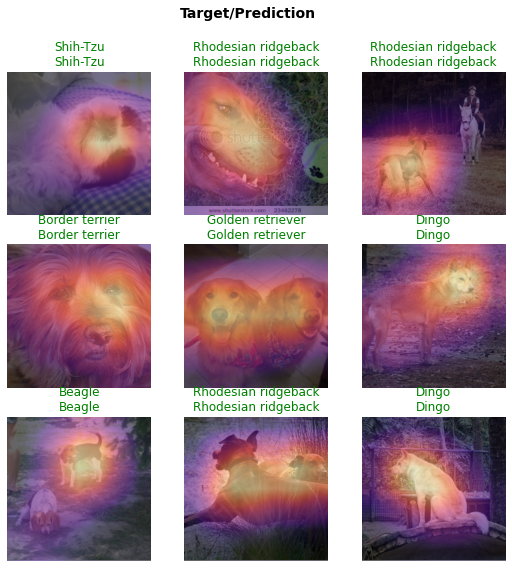

In [ ]:
interp.show_batch()

## 2. Grad-CAM

In [ ]:
#export
def generate_gradcam(model,x,y=None,act_path:list=[0],with_preds=False):
  """Show Grad-CAM for a given image
    `xb,yb`: input batch 
    `layer_idx`: list of indices to reach target layer
  """
  m = model.eval()
  hook_layer = get_module(m,act_path)
  if len(x.shape)==3: x = x.unsqueeze(0)
  with hook_output(hook_layer,grad=True) as hook_g:
    with hook_output(hook_layer) as hook:      
      m.zero_grad()
      y_pred = m(x)      
      if y is None:
        y = y_pred.argmax()
      y_pred[0,y].backward(retain_graph=True)      
      acts = hook.stored[0]
    grads = hook_g.stored[0]
    grads = grads.mean((2,3))
    gcam = F.relu(torch.einsum('ab,bcd->acd',grads,acts))
    
    del grads,acts
    torch.cuda.empty_cache()
    
    if with_preds: return gcam,y_pred
    return gcam

In [ ]:
learn = cnn_learner(dls,resnet34,pretrained=False)
learn.load('resnet34')

In [ ]:
m = learn.model.eval()

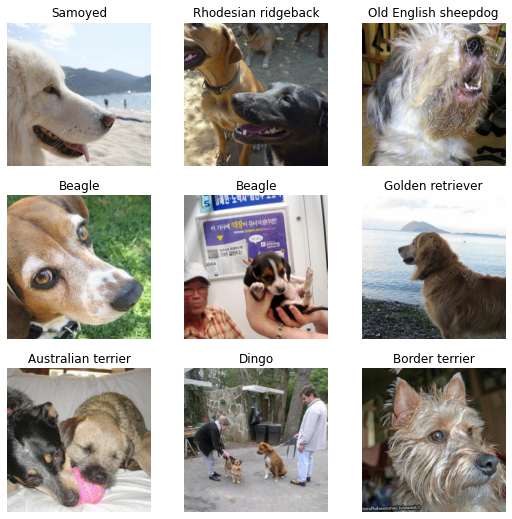

In [ ]:
dls.valid.shuffle=True
xb,yb = dls.one_batch()
dls.valid.shuffle = True
dls.show_batch((xb,yb))

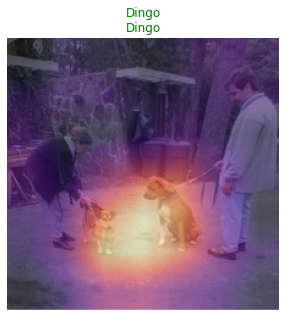

In [ ]:
idx=7
gcam,preds = generate_gradcam(m,xb[idx],yb[idx],with_preds=True)
x_dec,y_dec = dls.decode_batch((xb[idx][None],yb[idx][None]))[0]
pred_cls = dls.vocab[preds.argmax().item()]
cam_img = CamImage(x_dec,y_dec,pred_cls,gcam[0])
cam_img.show()

For Class: Beagle


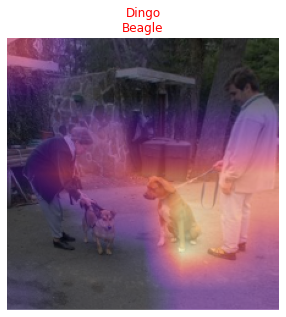

In [ ]:
for_cls = 1
lbl = dls.vocab[for_cls]
print(f"For Class: {lbl}")
cust_gcam = generate_gradcam(m,xb[idx],tensor(for_cls))
cam_img2 = cam_img.new(lbl,cust_gcam)
cam_img2.show()

In [ ]:
gcams = []
y_preds = []
for x,y in zip(xb,yb):
  gcam,preds = generate_gradcam(m,x,y,with_preds=True)
  gcams.append(gcam[0])
  y_preds.append(preds[0])

In [ ]:
gcam_batch,y_preds = torch.stack(gcams),torch.stack(y_preds)

In [ ]:
#export
def get_gcam_at(batch_dec,cam_batch,y_preds,vocab,idx):
  x,y = batch_dec[idx]
  cam_i = cam_batch[idx]
  class_id = y_preds[idx].argmax(-1).item()
  return CamImage(x,y,vocab[class_id],cam_i)

In [ ]:
#export
def show_gradcam_batch(xb,yb,cam_batch,y_preds,vocab,max_n=9,cmap='magma',
                       merge=True,guided=False,nrows=None, ncols=None,
                       figsize=None):
  merge = merge and not guided
  ctxs = get_grid(min(xb.shape[0],max_n),double=(not merge),add_vert=4,title='Target/Prediction')
  batch_dec = dls.decode_batch((xb,yb))  
  getter = partial(get_gcam_at,batch_dec,cam_batch,y_preds,vocab)  
  if merge:
    for idx,ctx in enumerate(ctxs):
      cam_img = getter(idx)
      cam_img.show(ctx=ctx,y_image=guided,cmap=cmap)
  else:
    for idx,ctx in enumerate(zip(ctxs[0::2],ctxs[1::2])):
      cam_img = getter(idx)
      cam_img.show(ctx=ctx,y_image=guided,cmap=cmap)

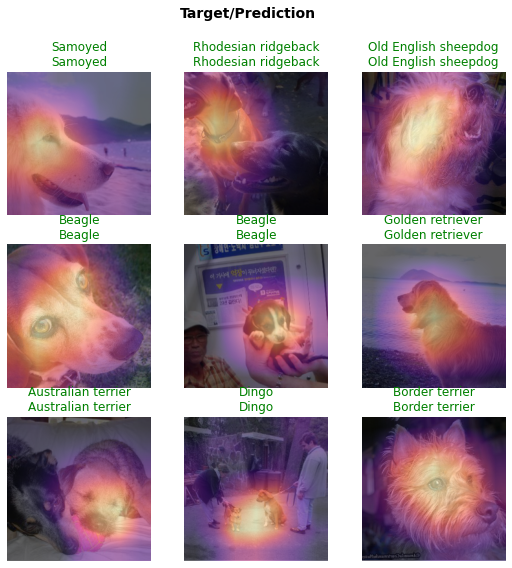

In [ ]:
show_gradcam_batch(xb,yb,gcam_batch,y_preds,dls.vocab)

In [ ]:
#export
class GradCamInterpreter(BaseInterpreter):
  
  def generate(self,xb=None,yb=None,act_path=[0],guided=False,with_preds=False):
    gcams = []
    y_preds = []

    if batch_none(xb,yb):
      xb,yb = self.valid_dl.one_batch()
      self.xb,self.yb = xb,yb # store for future reference

    for x,y in zip(xb,yb):
      gcam,preds = generate_gradcam(m,x,y,act_path=act_path,with_preds=True)

      if guided:
        gbviz = GuidedBackprop(self.model)
        gcam_up = F.interpolate(gcam[None],size=(224,224),mode='bilinear',align_corners=True)[0]
        gbprop = gbviz.guided_backprop(x[None],y[None])
        gcam = gcam_up * gbprop
        gcam.unsqueeze_(0)

      gcams.append(gcam[0])
      y_preds.append(preds[0])
    
    gcam_batch,y_preds = torch.stack(gcams),torch.stack(y_preds)
    
    del gcam,gcams
    if guided: 
      del gcam_up,gbprop
    torch.cuda.empty_cache()
    
    if with_preds:
      return gcam_batch,y_preds
    else:
      del y_preds
      return gcam_batch
 

  @delegates(show_gradcam_batch,but=['xb,yb,cam_batch,y_preds,vocab'])
  def show_batch(self,xb=None,yb=None,act_path=[0],guided=False,**kwargs):
    if batch_none(xb,yb) and not hasattrs(self,('xb','yb')):
      xb,yb = self.valid_dl.one_batch()
      self.xb,self.yb = xb,yb # store for further reference
    
    cam_batch,y_preds = self.generate(xb,yb,act_path=act_path,guided=guided,with_preds=True)
    if guided: 
      cam_batch = kornia.rgb_to_grayscale(cam_batch)
    show_gradcam_batch(self.xb,self.yb,cam_batch,y_preds,self.vocab,guided=guided,**kwargs)
  
  def show_at(self,idx,xb=None,yb=None,merge=True,cmap='magma',
              for_cls=None,act_path:list=[0],guided=False):
    merge = merge and not guided
    if batch_none(xb,yb) and not hasattrs(self,('xb','yb')):
      xb,yb = self.valid_dl.one_batch()
    else: xb,yb = self.xb,self.yb
    xib,yib = xb[idx][None],yb[idx][None]
    
    if for_cls is not None:
      yib = tensor(for_cls)[None]
    
    batch_dec = self.valid_dl.decode_batch((xib,yib))
    cam_b,y_preds = self.generate(xib,yib,guided=guided,with_preds=True)
    # if guided: cam_b = kornia.rgb_to_grayscale(cam_b)
    get_gcam_at(batch_dec,cam_b,y_preds,self.vocab,idx=0).show(merge=merge,y_image=True,cmap=cmap)

In [ ]:
interp = GradCamInterpreter.from_learner(learn)

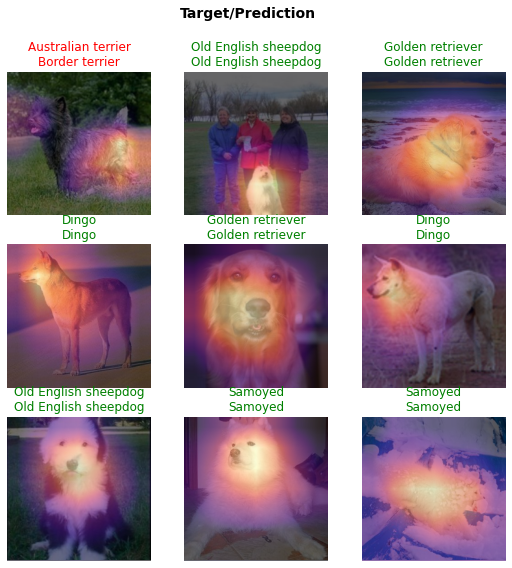

In [ ]:
interp.show_batch()

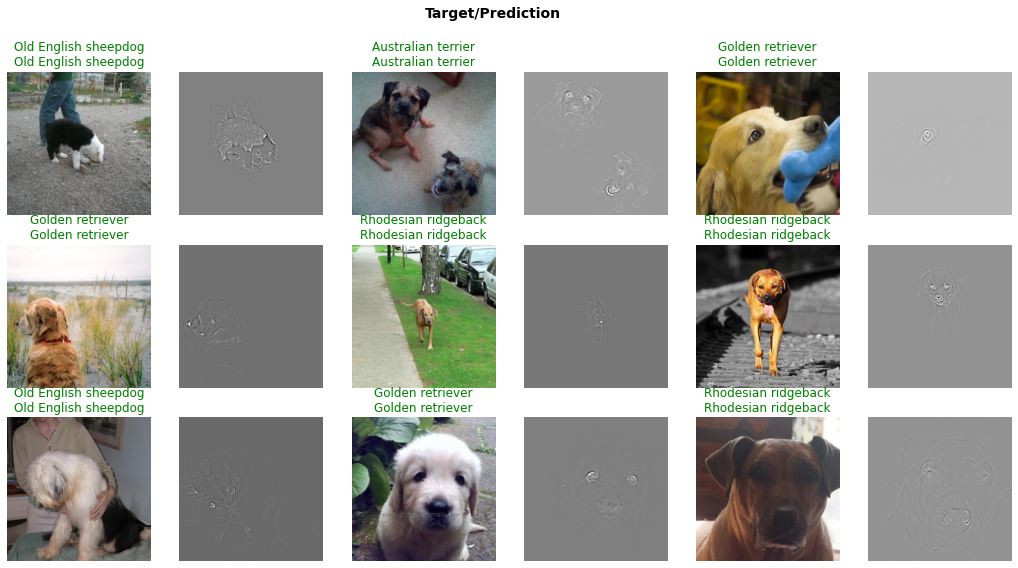

In [ ]:
interp.show_batch(guided=True,cmap='Greys')

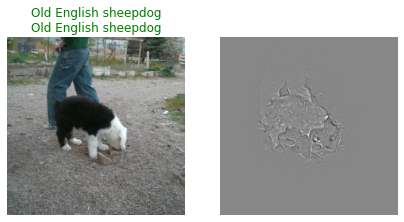

In [ ]:
interp.show_at(0,guided=True,cmap='Greys')